### Находим участки с __торможением__, __ускорением__ и __равномерной ездой__:

#### 1. Сначала импортируем модуль
```python
from src.utils import TSTrendEstimator
```
#### 2. Создаем датафрейм где указываем время, идентификатор авто и скорость
#### 3. Передаем эту таблицу в *TSTrendEstimator*
```python
result = TSTrendEstimator().fit_predict(df)
```
#### 4. Получаем *result*, где 
+ *X* это оригинальная скорость
+ *estimation* это оценка изменения скорости
+ *status*:
    + 1 это __ускорение__
    + 0 это __равномерная езда__
    + -1 это __торможение__

# 1. IMPORT 

In [61]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import src
from src.utils import TSTrendEstimator, plot_TSTrendEstimation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. LOAD DATA

In [2]:
PATH = '/home/jovyan/remote_shared_data/dsdiag222/temporary/from_ntc_batching/2020_04_26_2020_06_30_valid_distance_upd.csv'
USECOLS = ['time', 'speed', 'car_vin']

In [3]:
%%time

df = pd.read_csv(PATH, usecols=USECOLS)
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

CPU times: user 20.9 s, sys: 1.85 s, total: 22.8 s
Wall time: 45 s


### RESAMPLING

In [4]:
RESAMPLE_FREQ = '10s'

In [5]:
%%time

df_resampled = df.groupby('car_vin')['speed'].resample(RESAMPLE_FREQ).mean()
df_resampled.replace(0, np.nan, inplace=True)

CPU times: user 5.93 s, sys: 710 ms, total: 6.64 s
Wall time: 6.64 s


In [6]:
# Input data example
df_resampled.dropna().head(20).to_frame()

speed
car_vin           time                      
XTC549015J2510673 2020-04-26 05:25:20   1.75
                  2020-04-26 05:26:50   1.00
                  2020-04-26 05:27:00   0.25
                  2020-04-26 05:28:30   0.75
                  2020-04-26 05:29:00   0.50
                  2020-04-26 05:29:10   0.25
                  2020-04-26 05:30:00   0.25
                  2020-04-26 05:30:30   0.25
                  2020-04-26 05:31:10   0.25
                  2020-04-26 05:32:00   0.25
                  2020-04-26 05:32:50   2.25
                  2020-04-26 05:33:20   0.25
                  2020-04-26 05:33:30   1.00
                  2020-04-26 06:30:00   0.25
                  2020-04-26 06:30:20   3.75
                  2020-04-26 06:30:30   7.75
                  2020-04-26 06:30:40   8.50
                  2020-04-26 06:30:50   9.75
                  2020-04-26 06:31:00   8.75
                  2020-04-26 06:31:10   9.50

# 3. TREND ESTIMATION

In [63]:
%time res = TSTrendEstimator(alpha=10, min_coef=-1, max_coef=1).fit_predict(df_resampled)

CPU times: user 26.8 s, sys: 5.8 s, total: 32.6 s
Wall time: 27.9 s


In [14]:
# # Or for single car
# %time TSTrendEstimator().fit_predict(df_resampled.loc['XTC549015J2510673']).dropna()

CPU times: user 1.53 s, sys: 1.23 s, total: 2.76 s
Wall time: 231 ms


,X,estimation,status
time,,,
2020-04-26 06:38:40,82.166667,9.515766,1.0
2020-04-26 06:38:50,82.000000,6.907658,1.0
2020-04-26 06:39:00,79.666667,3.805180,1.0
2020-04-26 06:39:10,76.333333,0.891892,0.0
2020-04-26 06:39:20,73.208333,-1.256757,0.0
...,...,...,...
2020-06-27 02:58:00,81.500000,-0.364114,0.0
2020-06-27 02:58:10,81.833333,-0.352853,0.0
2020-06-27 02:58:20,82.250000,-0.157658,0.0


# 4. RESULT

In [16]:
vin_list = df['car_vin'].unique()

In [83]:
%time res = TSTrendEstimator(alpha=0, min_coef=-0.25, max_coef=0.25).fit_predict(df_resampled)

CPU times: user 28.9 s, sys: 4.95 s, total: 33.9 s
Wall time: 29.3 s


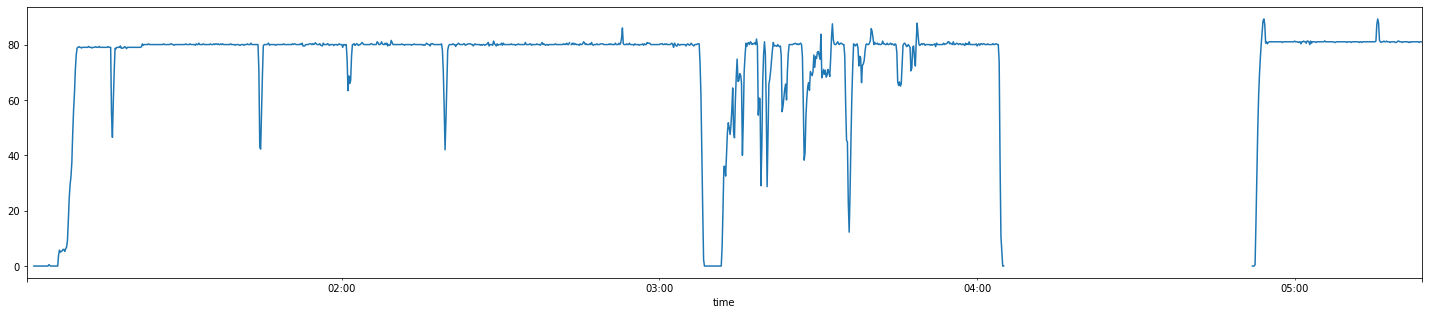

In [151]:
df.query('car_vin == @rand_vin')['speed'].head(5_000).resample('10s').mean().plot(figsize=(25,5))

XTC549015J2518861


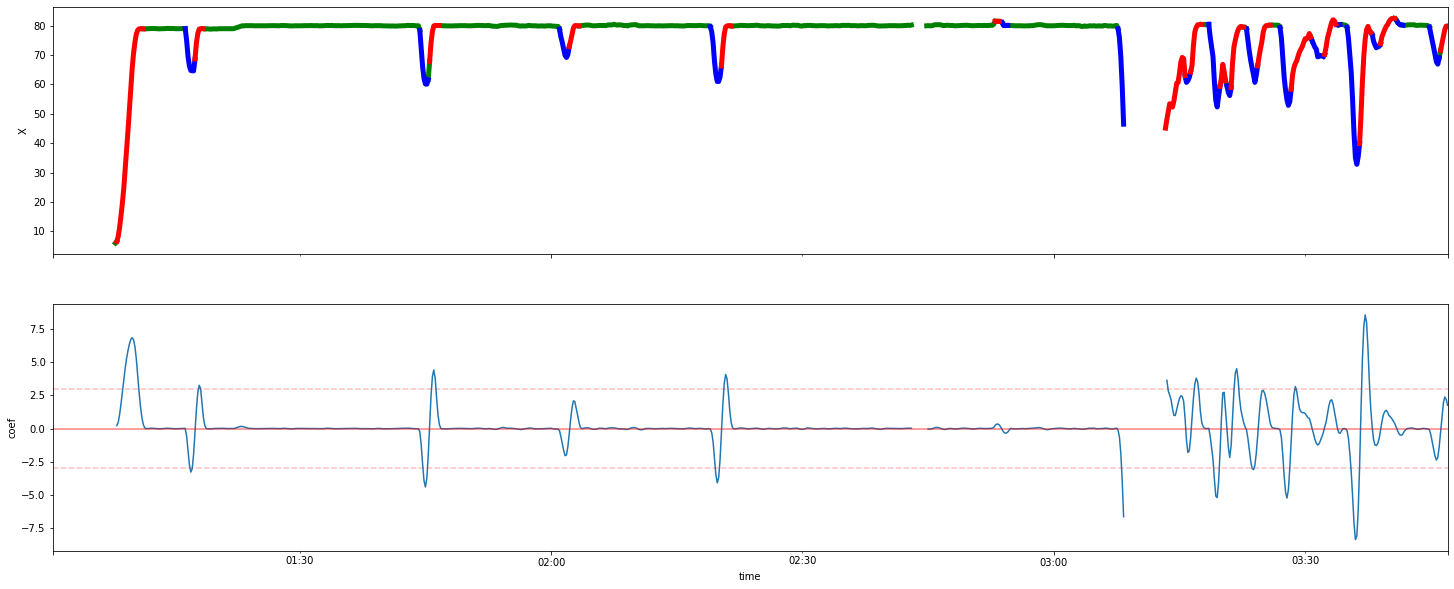

In [140]:
rand_vin = np.random.choice(vin_list)
print(rand_vin)
plot_TSTrendEstimation(res.loc[rand_vin].head(1_000), max_coef=3, min_coef=-3, n_lags=2)

# STASH

In [183]:
rand_vin = np.random.choice(vin_list)

In [184]:
df_orig = df.loc[rand_vin]
df_score = res.loc[rand_vin]
tmp = pd.merge_asof(df_orig, df_score, left_index=True, right_index=True)

XTC549015K2520656


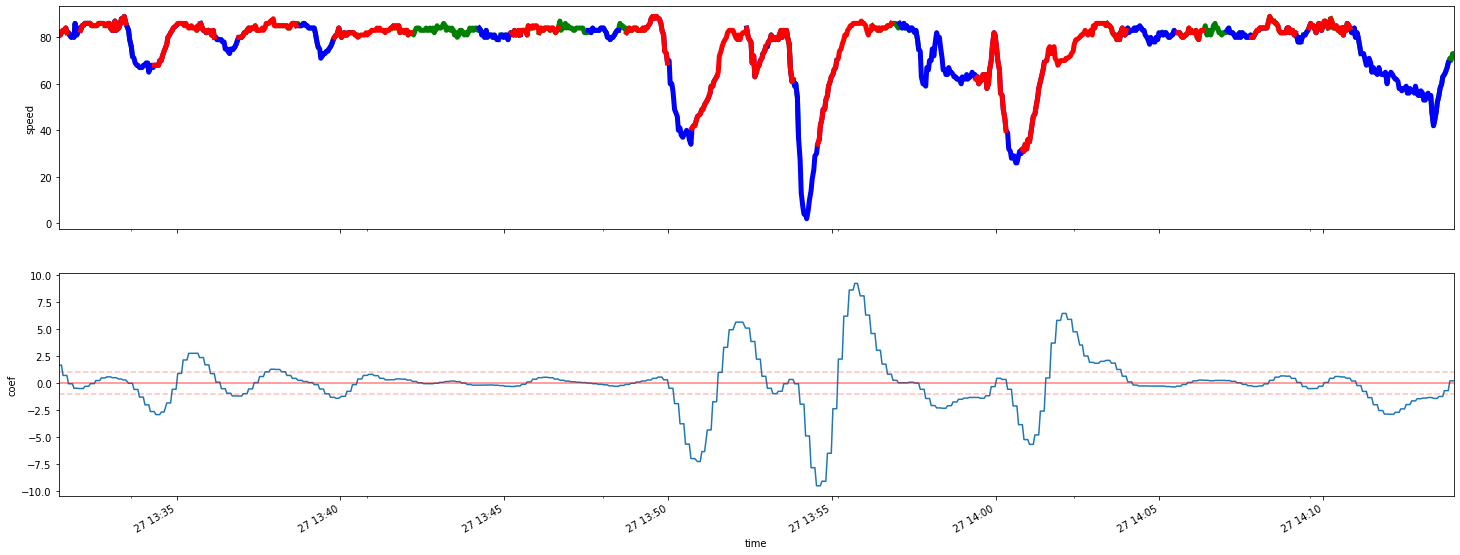

In [223]:
rand_vin = np.random.choice(vin_list)
print(rand_vin)
plot_TSTrendEstimation(tmp.head(5_000).tail(1_000), value='speed', max_coef=1, min_coef=-1, n_lags=6)